# Results
stft_3x3: 65%

stft_1x1:

### Import Libraries

Import necessary libraries

In [29]:
import glob
import os
import librosa
import librosa.display
import time
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
import noisereduce as nr
import matplotlib.pyplot as plt
from matplotlib import cm
import skimage.io
import re
from IPython.display import display, Image
%matplotlib inline
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential

In [30]:
RATE = 16000
TOP_DB = 25

In [31]:
def stft(data):
    data = np.abs(librosa.stft(data, hop_length=512, n_fft=2048))
    return librosa.power_to_db(data, ref=np.max)

def chroma(data):
    data = stft(data)
    return librosa.feature.chroma_stft(S=stft, sr=RATE)

def mel(data):
    mels = librosa.feature.melspectrogram(y=data, sr=RATE)
    return librosa.power_to_db(data, ref=np.max)

def mfcc(data):
    return librosa.feature.mfcc(y=data, sr=RATE, n_fft=2048, hop_length=512)

In [32]:
def create_images_from_feature(df: pd.DataFrame, op, dim):

    _fig, ax = plt.subplots(1, figsize=(dim, dim))
    for i, row in tqdm(df.iterrows(), total=len(df)):
        y, sr = librosa.load(row['File_Path'], sr=RATE, res_type='kaiser_best')
        y, _ = librosa.effects.trim(y, top_db=TOP_DB)
        y = nr.reduce_noise(y, sr=sr)
        data = mel(y)
        emo = row['Emotion']

        image = librosa.display.specshow(data, ax=ax, sr=sr, y_axis='linear')
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.set_frame_on(False)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        plt.jet()
        _fig.savefig(f'{op}/{emo}-{i}.png')
        plt.cla()
    plt.close(_fig)
    plt.close("all")

# Building Dataframe

In [33]:
Crema_Path='../Datasets/Crema/'
Ravdess_Path='../Datasets/Ravdess/'
Savee_Path='../Datasets/Savee/'
Tess_Path='../Datasets/Tess/'

In [34]:
crema=[]
for wav in os.listdir(Crema_Path):
    emotion=wav.partition(".wav")[0].split('_')
    if emotion[2]=='SAD':
        crema.append(('sad',Crema_Path+'/'+wav))
    elif emotion[2]=='ANG':
        crema.append(('angry',Crema_Path+'/'+wav))
    elif emotion[2]=='DIS':
        crema.append(('disgust',Crema_Path+'/'+wav))
    elif emotion[2]=='FEA':
        crema.append(('fear',Crema_Path+'/'+wav))
    elif emotion[2]=='HAP':
        crema.append(('happy',Crema_Path+'/'+wav))
    elif emotion[2]=='NEU':
        crema.append(('neutral',Crema_Path+'/'+wav))
    else:
        crema.append(('unknown',Crema_Path+'/'+wav))
Crema_df=pd.DataFrame.from_dict(crema)
Crema_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
Crema_df.head()

,Emotion,File_Path
0,angry,../Datasets/Crema//1072_IOM_ANG_XX.wav
1,fear,../Datasets/Crema//1048_IOM_FEA_XX.wav
2,angry,../Datasets/Crema//1073_IEO_ANG_LO.wav
3,happy,../Datasets/Crema//1012_WSI_HAP_XX.wav
4,happy,../Datasets/Crema//1073_TSI_HAP_XX.wav


In [35]:
ravdess=[]
for directory in os.listdir(Ravdess_Path):
    actors=os.listdir(os.path.join(Ravdess_Path,directory))
    for wav in actors:
        emotion=wav.partition('.wav')[0].split('-')
        emotion_number=int(emotion[2])
        ravdess.append((emotion_number,os.path.join(Ravdess_Path,directory,wav)))
Ravdess_df=pd.DataFrame.from_dict(ravdess)
Ravdess_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
Ravdess_df['Emotion'].replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'},inplace=True)
Ravdess_df.head()

,Emotion,File_Path
0,neutral,../Datasets/Ravdess/Actor_08/03-01-02-01-01-01...
1,sad,../Datasets/Ravdess/Actor_08/03-01-04-02-02-02...
2,neutral,../Datasets/Ravdess/Actor_08/03-01-02-01-02-01...
3,happy,../Datasets/Ravdess/Actor_08/03-01-03-01-02-01...
4,fear,../Datasets/Ravdess/Actor_08/03-01-06-01-02-02...


In [36]:
savee=[]
for wav in os.listdir(Savee_Path):
    emo=wav.partition('.wav')[0].split('_')[1].replace(r'[0-9]','')
    emotion=re.split(r'[0-9]',emo)[0]
    if emotion=='a':
        savee.append(('angry',Savee_Path+'/'+wav))
    elif emotion=='d':
        savee.append(('disgust',Savee_Path+'/'+wav))
    elif emotion=='f':
        savee.append(('fear',Savee_Path+'/'+wav))
    elif emotion=='h':
        savee.append(('happy',Savee_Path+'/'+wav))
    elif emotion=='n':
        savee.append(('neutral',Savee_Path+'/'+wav))
    elif emotion=='sa':
        savee.append(('sad',Savee_Path+'/'+wav))
    elif emotion=='su':
        savee.append(('surprise',Savee_Path+'/'+wav))
Savee_df=pd.DataFrame.from_dict(savee)
Savee_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
Savee_df.head()

,Emotion,File_Path
0,fear,../Datasets/Savee//KL_f05.wav
1,disgust,../Datasets/Savee//KL_d11.wav
2,neutral,../Datasets/Savee//DC_n06.wav
3,disgust,../Datasets/Savee//DC_d06.wav
4,surprise,../Datasets/Savee//DC_su06.wav


In [37]:
tess=[]
for directory in os.listdir(Tess_Path):
    for wav in os.listdir(os.path.join(Tess_Path,directory)):
        emotion=wav.partition('.wav')[0].split('_')
        if emotion[2]=='ps':
            tess.append(('surprise',os.path.join(Tess_Path,directory,wav)))
        else:
            tess.append((emotion[2],os.path.join(Tess_Path,directory,wav)))
Tess_df=pd.DataFrame.from_dict(tess)
Tess_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
Tess_df.head()

,Emotion,File_Path
0,surprise,../Datasets/Tess/OAF_Pleasant_surprise/OAF_dab...
1,surprise,../Datasets/Tess/OAF_Pleasant_surprise/OAF_mak...
2,surprise,../Datasets/Tess/OAF_Pleasant_surprise/OAF_bea...
3,surprise,../Datasets/Tess/OAF_Pleasant_surprise/OAF_hal...
4,surprise,../Datasets/Tess/OAF_Pleasant_surprise/OAF_pas...


In [38]:
main_df=pd.concat([Crema_df,Ravdess_df,Savee_df,Tess_df],axis=0)
main_df.shape

(12162, 2)

In [39]:
main_df.head(15)

,Emotion,File_Path
0,angry,../Datasets/Crema//1072_IOM_ANG_XX.wav
1,fear,../Datasets/Crema//1048_IOM_FEA_XX.wav
2,angry,../Datasets/Crema//1073_IEO_ANG_LO.wav
3,happy,../Datasets/Crema//1012_WSI_HAP_XX.wav
4,happy,../Datasets/Crema//1073_TSI_HAP_XX.wav
5,happy,../Datasets/Crema//1089_TSI_HAP_XX.wav
6,disgust,../Datasets/Crema//1031_MTI_DIS_XX.wav
7,disgust,../Datasets/Crema//1037_ITH_DIS_XX.wav
8,sad,../Datasets/Crema//1075_IEO_SAD_HI.wav
9,disgust,../Datasets/Crema//1051_MTI_DIS_XX.wav


In [40]:
main_df = main_df[main_df['Emotion'] != 'surprise']

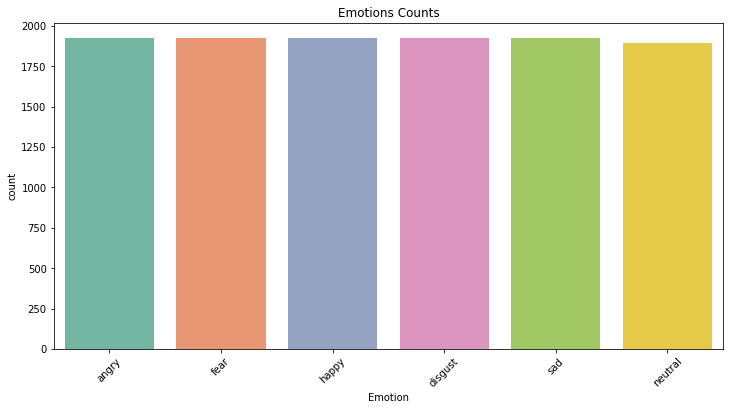

In [41]:
plt.figure(figsize=(12,6))
plt.title('Emotions Counts')
emotions=sns.countplot(x='Emotion',data=main_df,palette='Set2')
emotions.set_xticklabels(emotions.get_xticklabels(),rotation=45)
plt.show()

# Generating Images

  0%|          | 0/11510 [00:00<?, ?it/s]


IndexError: tuple index out of range

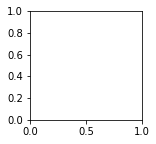

In [42]:
feature_folder = './features/images/mel_mod_2x2'
create_images_from_feature(main_df, feature_folder, 2)

In [ ]:
prin('...')

In [19]:
images = []
labels = []

for dirname, _, files in os.walk('/kaggle/working/graphs'):
    for file in files:
        file_path = os.path.join(dirname, file)
        images.append(file_path)
        labels.append(file_path.split('-')[0].split('/')[-1])
        

In [20]:
len(images), len(labels)

In [21]:
di = {
    'image': images,
    'label': labels
}

In [22]:
df = pd.DataFrame(di)

In [23]:
df.shape

In [24]:
df.head

In [25]:
df.columns

In [26]:
np.unique(df['label'])

In [27]:
import random

index = random.randint(0, 2800)

plt.imshow(plt.imread(df['image'][index]))
plt.title('emotion: ' + df['label'][index])

## Shuffling data#reindexing to shuffle the data at random

In [28]:
#reindexing to shuffle the data at random
df = df.reindex(np.random.permutation(df.index))
df.reset_index(drop=True, inplace=True)

In [29]:
df.head

In [30]:
len(df)

## Splitting Dataset

In [31]:
# Defines ratios, w.r.t. whole dataset.
ratio_train = 0.7
ratio_val = 0.15
ratio_test = 0.15

# Produces test split.
remaining, test = train_test_split(
    df, test_size=ratio_test, stratify=df['label'])

# Adjusts val ratio, w.r.t. remaining dataset.
ratio_remaining = 1 - ratio_test
ratio_val_adjusted = ratio_val / ratio_remaining

# Produces train and val splits.
train, val = train_test_split(
    remaining, test_size=ratio_val_adjusted, stratify=remaining['label'])

In [32]:
# train, val = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=69)

In [33]:
len(train), len(val), len(test)

In [34]:
train.head(), val.head(), test.head()

In [35]:
train['label'].value_counts()

In [36]:
val['label'].value_counts()

In [37]:
test['label'].value_counts()

In [38]:
import PIL

image = PIL.Image.open(df['image'][2])

width, height = image.size

print(width, height)
display(image)

In [39]:
from keras.preprocessing.image import ImageDataGenerator

In [40]:
datagen = ImageDataGenerator(rescale = 1./255)

In [41]:
train_set = datagen.flow_from_dataframe(
    dataframe=train,
#     directory="face_mask_detection/train",
    x_col="image",
    y_col="label",
    batch_size=32,
#     shuffle=True,
    class_mode="categorical",
    target_size=(width, height))

In [42]:
val_set = datagen.flow_from_dataframe(
    dataframe=val,
#     directory="face_mask_detection/train",
    x_col="image",
    y_col="label",
    batch_size=32,
#     shuffle=True,
    class_mode="categorical",
    target_size=(width, height))

In [43]:
test_set = datagen.flow_from_dataframe(
    dataframe=test,
#     directory="face_mask_detection/train",
    x_col="image",
    y_col="label",
    batch_size=32,
    shuffle=False,
    class_mode="categorical",
    target_size=(width, height))

# Model Creation

In [44]:
image_size = [width, height]
vgg = VGG16(input_shape = image_size + [3], weights = 'imagenet', include_top =  False)
for layer in vgg.layers:
    layer.trainable = False
    
# vgg.trainable = False

x = Flatten()(vgg.output)
prediction = Dense(len(np.unique(df['label'])), activation = 'softmax')(x)

In [45]:
model = Model(inputs = vgg.input, outputs = prediction)
model.summary()

In [46]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# Training

In [47]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

EPOCH = 100
STEP_SIZE_TRAIN = train_set.n//train_set.batch_size
STEP_SIZE_VALID = val_set.n//val_set.batch_size
STEP_SIZE_TEST = test_set.n//test_set.batch_size

es_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

mc = ModelCheckpoint('./mode_ckpt', save_best_only=True, save_weights_only=True, verbose=1)

lrs = ReduceLROnPlateau(monitor="val_loss",
    factor=0.5,
    patience=3,
    verbose=1,
    mode="auto",
    min_lr=1e-6)

In [ ]:
mod = model.fit(
  train_set,
  validation_data=val_set,
  epochs=500,
  callbacks=[es_callback, mc, lrs],
  steps_per_epoch=STEP_SIZE_TRAIN,
  validation_steps=STEP_SIZE_VALID,
  use_multiprocessing=True,
  workers=10
)

In [ ]:
plt.plot(mod.history['loss'], label='train loss')
plt.plot(mod.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(mod.history['accuracy'], label='train accuracy')
plt.plot(mod.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [ ]:
# save it as a h5 file
from tensorflow.keras.models import load_model
model.save('model.h5')

# Evaulation

In [ ]:
tess_emotions = np.unique(df['label'])
tess_emotions

In [ ]:
x, y = zip(*(test_set[i] for i in range(len(test_set))))
x_test, y_test = np.vstack(x), np.vstack(y)

result = model.evaluate(x_test, y_test)
result

In [ ]:
# preds = model.predict(test_set, batch_size=STEP_SIZE_TEST)
preds = model.predict(test_set)
print(preds)

In [ ]:
print(test_set.classes)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred = np.argmax(preds, axis=1)
print(classification_report(test_set.classes,y_pred))



# Confusion Matrix
cm = confusion_matrix(test_set.classes, y_pred)
# print(cm)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(tess_emotions);
ax.yaxis.set_ticklabels(tess_emotions);

# Fine-Tuning

In [ ]:
# model_ft = model
# # image_size = [width, height]
# # vgg2 = VGG16(input_shape = image_size + [3], weights = 'imagenet', include_top =  False)

    
# # # vgg.trainable = False

# # x = Flatten()(vgg.output)
# # prediction = Dense(len(np.unique(df['label'])), activation = 'softmax')(x)
# # model_ft = Model(inputs = vgg2.input, outputs = prediction)

In [ ]:
# #Un-Freezing last 2 blocks(i.e. block4 and 5)

# model_ft.trainable = True

# set_trainable = False
# for layer in model_ft.layers:
#     if layer.name == 'block4_conv1':
#         set_trainable = True
#     if set_trainable:
#         layer.trainable = True
#     else:
#         layer.trainable = False
        
# model_ft.summary()

In [ ]:
# model_ft.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# mod2 = model_ft.fit(
#   train_set,
#   validation_data=val_set,
#   epochs=500,
#   callbacks=[es_callback, mc, lrs],
#   steps_per_epoch=STEP_SIZE_TRAIN,
#   validation_steps=STEP_SIZE_VALID,
#   use_multiprocessing=True,
#   workers=10
# )

In [ ]:
# plt.plot(mod2.history['loss'], label='train loss')
# plt.plot(mod2.history['val_loss'], label='val loss')
# plt.legend()
# plt.show()

In [ ]:
# plt.plot(mod2.history['accuracy'], label='train accuracy')
# plt.plot(mod2.history['val_accuracy'], label='val_accuracy')
# plt.legend()
# plt.show()

In [ ]:
# model.save('model_ft.h5')

In [ ]:
# x, y = zip(*(test_set[i] for i in range(len(test_set))))
# x_test, y_test = np.vstack(x), np.vstack(y)

result_ft = model_ft.evaluate(x_test, y_test)
result_ft

In [ ]:
# # preds = model.predict(test_set, batch_size=STEP_SIZE_TEST)
# preds_ft = model_ft.predict(test_set)
# print(preds_ft)

In [ ]:
# y_pred_ft = np.argmax(preds_ft, axis=1)
# print(classification_report(test_set.classes, y_pred_ft))

# # Confusion Matrix
# cm_ft = confusion_matrix(test_set.classes, y_pred_ft)
# # print(cm)
# ax = plt.subplot()
# sns.heatmap(cm_ft, annot=True, fmt='g', ax=ax);
# # labels, title and ticks
# ax.set_xlabel('Predicted labels');
# ax.set_ylabel('True labels'); 
# ax.set_title('Confusion Matrix'); 
# ax.xaxis.set_ticklabels(tess_emotions);
# ax.yaxis.set_ticklabels(tess_emotions);